In [340]:
import os

import numpy as np

from scipy.optimize import minimize_scalar

import pandas as pd

import cmasher
from matplotlib import pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['figure.figsize'] = [5.75, 2.5]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = ['o', 'x', 'D', 'v', '^', 'p', '*', 'h', 'H', 'd', 'P', 'X']
line_cycle = ['-', '--', '-.', ':']

In [145]:
# MNIST regression experiment

base_dir = os.path.join('figure_data', 'mnist_reg')

to_load = [
    'data',
    'K0',
    'Kbar',
    'Kfinal',
    'Ksupp',
    'Kyy',
    'pca_components',
    'ysmooth',
    'yhat'
]

mnist_reg = {}
for name in to_load:
    mnist_reg[name] = np.load(os.path.join(base_dir, name + '.npy'))
    if name != 'pca_components':
        mnist_reg[f"{name}2"] = np.load(os.path.join(base_dir, f"2{name}.npy"))

y_smooth = mnist_reg['ysmooth']
idx = np.argsort(y_smooth.ravel())
y_smooth = y_smooth[idx]

X = mnist_reg['data'][idx, :]
y = mnist_reg['yhat'][idx, 0]
Kyy = mnist_reg['Kyy'][idx, :, 0][:, idx]
K0 = mnist_reg['K0'][idx, :, 0][:, idx]
Kbar = mnist_reg['Kbar'][idx, :, 0][:, idx]
Kfinal = mnist_reg['Kfinal'][idx, :, 0][:, idx]
Ksupp = mnist_reg['Ksupp'][idx, :, 0][:, idx]
U = mnist_reg['pca_components'][idx, :]

y_smooth2 = mnist_reg['ysmooth2']
idx = np.argsort(y_smooth2.ravel())
y_smooth2 = y_smooth2[idx]

X2 = mnist_reg['data'][idx, :]
y2 = mnist_reg['yhat2'][idx, 0]
Kyy2 = mnist_reg['Kyy2'][idx, :, 0][:, idx]
K02 = mnist_reg['K02'][idx, :, 0][:, idx]
Kbar2 = mnist_reg['Kbar2'][idx, :, 0][:, idx]
Kfinal2 = mnist_reg['Kfinal2'][idx, :, 0][:, idx]
Ksupp2 = mnist_reg['Ksupp2'][idx, :, 0][:, idx]

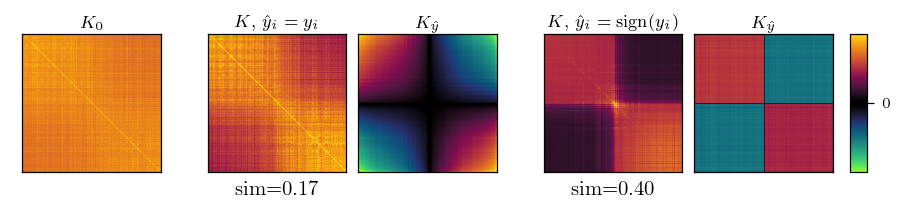

In [338]:
def cos_sim(x, y):
    return np.sum(x * y) / (np.linalg.norm(x, 'fro') * np.linalg.norm(y, 'fro'))

cmap = cmasher.wildfire
vmax_K0 = 4
vmax_Kbar = 10
vmax_Kyy = 2

fig, axes = plt.subplots(1, 5, figsize=(5.75, 2.5), dpi=150)

axes[0].imshow(K02, cmap=cmap, vmin=-vmax_K0, vmax=vmax_K0)
axes[0].set_title(r"$K_0$")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(Kbar2, cmap=cmap, vmin=-vmax_Kbar, vmax=vmax_Kbar)
axes[1].set_title(r"$K$, $\hat{y}_i = y_i$")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel(f"sim={cos_sim(Kbar2, Kyy2):.2f}")

axes[2].imshow(Kyy2, cmap=cmap, vmin=-vmax_Kyy, vmax=vmax_Kyy)
axes[2].set_title(r"$K_{\hat{y}}$")
axes[2].set_xticks([])
axes[2].set_yticks([])

axes[3].imshow(Kbar, cmap=cmap, vmin=-vmax_Kbar, vmax=vmax_Kbar)
axes[3].set_title(r"$K$, $\hat{y}_i = \mathrm{sign}(y_i)$")
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_xlabel(f"sim={cos_sim(Kbar, Kyy):.2f}")

axes[4].imshow(Kyy, cmap=cmap, vmin=-vmax_Kyy, vmax=vmax_Kyy)
axes[4].set_title(r"$K_{\hat{y}}$")
axes[4].set_xticks([])
axes[4].set_yticks([])

plt.tight_layout()

# move axes[1] to the right
pos = axes[1].get_position()
pos.x0 += 0.02
pos.x1 += 0.02
axes[1].set_position(pos)

# move axes[3] to the right
pos = axes[3].get_position()
pos.x0 += 0.02
pos.x1 += 0.02
axes[3].set_position(pos)

# create a colorbar on the right as new axis
pos = axes[4].get_position()
cax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
plt.colorbar(axes[4].images[0], cax=cax)
cax.set_yticks([0])

plt.savefig(os.path.join('figures', 'mnist_reg_kernel.pdf'), bbox_inches='tight')
plt.show()

In [319]:
vmin = 1
vmax = 50

def oplus(w1, w2, v, q=1000):

    def f(z):
        return w1(z) + w2(v / z)
    
    if v == 1:
        return 0
    
    zs = 1 + np.logspace(-8, np.log10(v - 1), q)
    fs = np.array([f(z) for z in zs])

    return min(fs)
    # return minimize_scalar(f, bounds=(1 + 1e-16, v - 1e-16), method='bounded').fun

def tilde(w, v, q=1000):

    def f(z):
        return w(z) + v ** 2 / z ** 2
    
    if v == 0:
        return 0
    
    zs = 1 + np.logspace(-8, 8, q)
    fs = np.array([f(z) for z in zs])

    return min(fs)
    # return minimize_scalar(f, bounds=(vmin, vmax), method='bounded').fun

w1 = lambda z: abs(1 - z) ** 2
w2 = lambda z: abs(1 - z) ** 1

w3_base = lambda v: oplus(w1, w2, v)

vs = np.linspace(vmin, vmax, 1000)

w1s = np.array([w1(v) for v in vs])
w2s = np.array([w2(v) for v in vs])
w3s = np.array([w3_base(v) for v in vs])

def w3(v):
    return np.interp(v, vs, w3s)

w1tilde = lambda v: tilde(w1, v)
w2tilde = lambda v: tilde(w2, v)
w3tilde = lambda v: tilde(w3, v)

zs = np.linspace(0, 5, 300)

w1tildes = np.array([w1tilde(z) for z in zs])
w2tildes = np.array([w2tilde(z) for z in zs])
w3tildes = np.array([w3tilde(z) for z in zs])


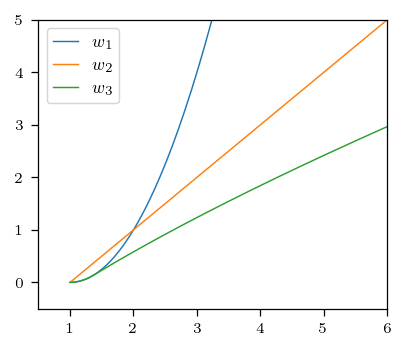

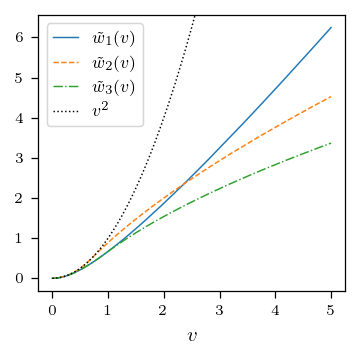

In [328]:
plt.figure(figsize=(3, 2.5), dpi=150)

plt.plot(vs, w1s, label=r"$w_1$")
plt.plot(vs, w2s, label=r"$w_2$")
plt.plot(vs, w3s, label=r"$w_3$")
plt.xlim(0.5, 6)
plt.ylim(-0.5, 5)
plt.legend()
plt.show()

plt.figure(figsize=(2.5, 2.5), dpi=150)

plt.plot(zs, w1tildes, linestyle=line_cycle[0], label=r"$\tilde{w}_1(v)$")
plt.plot(zs, w2tildes, linestyle=line_cycle[1], label=r"$\tilde{w}_2(v)$")
plt.plot(zs, w3tildes, linestyle=line_cycle[2], label=r"$\tilde{w}_3(v)$")

ylim = plt.ylim()
plt.plot(zs, zs ** 2, linestyle=line_cycle[3], color='black', label=r"$v^2$")
plt.ylim(ylim)

plt.xlabel(r"$v$")

plt.legend()
plt.tight_layout()

plt.savefig(os.path.join('figures', 'penalties.pdf'), bbox_inches='tight')
plt.show()

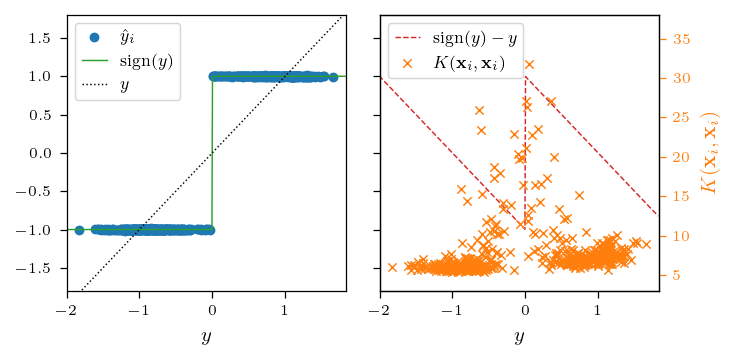

In [339]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharex=True, sharey=True)

ax = axes[0]
ax.scatter(y_smooth, y, label=r'$\hat{y}_i$')
xlim = ax.get_xlim()
ylim = [-1.8, 1.8]

y_fun = np.linspace(min(y_smooth), max(y_smooth), 500) * 1.1
ax.plot(y_fun, np.sign(y_fun), linestyle=line_cycle[0], color=color_cycle[2], label=r'$\mathrm{sign}(y)$')
ax.plot(y_fun, y_fun, color='black', linestyle=line_cycle[3], label=r'$y$')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$y$')
ax.legend()

ax = axes[1]
p1 = ax.plot(y_fun, np.sign(y_fun) - y_fun, linestyle=line_cycle[1], color=color_cycle[3], label=r'$\mathrm{sign}(\hat{y}_\mathrm{smooth}) - \hat{y}_\mathrm{smooth}$')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$y$')

twinx = ax.twinx()

diag_Ksupp = np.diag(Kbar)
p2 = twinx.scatter(y_smooth, diag_Ksupp, color=color_cycle[1], marker=marker_cycle[1])
twinx.set_xlim(xlim)
twinx.set_ylim([3, 38])

# set y ticks color
twinx.tick_params(axis='y', colors=color_cycle[1])
twinx.set_ylabel(r'$K(\mathbf{x}_i, \mathbf{x}_i)$', color=color_cycle[1])

ax.legend(p1 + [p2], [r'$\mathrm{sign}(y) - y$', r'$K(\mathbf{x}_i, \mathbf{x}_i)$'], loc='upper left')

plt.tight_layout()

plt.savefig(os.path.join('figures', 'mnist_reg.pdf'), bbox_inches='tight')
plt.show()

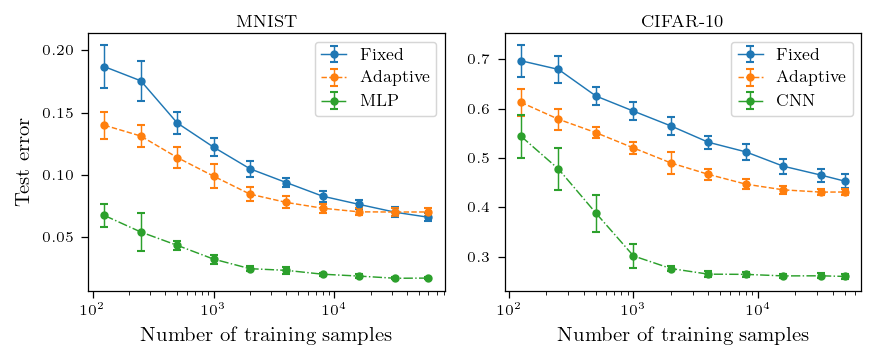

In [350]:
pkl_dir = os.path.join('figure_data', 'mnist_cifar10')

exps = ['linear', 'factorized', 'full']

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

ax = axes[0]
dataset = 'mnist'
names = ['Fixed', 'Adaptive', 'MLP']

for i, (exp, name) in enumerate(zip(exps, names)):
    df = pd.read_pickle(os.path.join(pkl_dir, f'{dataset}_{exp}.pkl'))
    df["test_error"].plot(ax=ax, y="mean", yerr="std", linestyle=line_cycle[i], label=name, capsize=2, marker="o", ms=3)

ax.set_xscale('log')
ax.set_xlabel('Number of training samples')
ax.set_ylabel('Test error')
ax.legend()
ax.set_title('MNIST')

ax = axes[1]
dataset = 'cifar10'
names = ['Fixed', 'Adaptive', 'CNN']

for i, (exp, name) in enumerate(zip(exps, names)):
    df = pd.read_pickle(os.path.join(pkl_dir, f'{dataset}_{exp}.pkl'))
    df["test_error"].plot(ax=ax, y="mean", yerr="std", linestyle=line_cycle[i], label=name, capsize=2, marker="o", ms=3)

ax.set_xscale('log')
ax.set_xlabel('Number of training samples')
ax.legend()
ax.set_title('CIFAR-10')

plt.tight_layout()

plt.savefig(os.path.join('figures', 'mnist_cifar10.pdf'), bbox_inches='tight')
plt.show()